In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from torchvision import transforms
from PIL import Image
import os
import torch.nn.functional as F
from tqdm import tqdm
import torchvision
import random
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


class SketchDataset(Dataset):
    def __init__(self, csv_file, image_root_dir, sketch_root_dir, transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.image_root_dir = image_root_dir
        self.sketch_root_dir = sketch_root_dir
        self.transform = transform
        self.num_sketches = 3594  # Update with the actual number of sketches
        self.num_samples = len(self.data_frame)

        # Compute variance of the data
        # self.variance = self.compute_variance().to(device)

    def compute_variance(self):
        # Load all images and compute variance
        data = []
        for idx in tqdm(range(len(self))):
            img_name = os.path.join(self.image_root_dir, self.data_frame.iloc[idx, 0] + '.jpg')
            image = Image.open(img_name).convert('RGB')
            if self.transform:
                image = self.transform(image)
            data.append(image.numpy())

        data = np.array(data)
        data = torch.from_numpy(data).to(device)
        return torch.var(data / 255.0)

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_root_dir, self.data_frame.iloc[idx, 0] + '.jpg')
        sketch_idx = idx % self.num_sketches  # Cyclic indexing for sketches
        sketch_name = os.path.join(self.sketch_root_dir, f"sketch_{sketch_idx + 1}.png")
        
        image = Image.open(img_name).convert('RGB')
        sketch = Image.open(sketch_name).convert('RGB')

        label = torch.tensor(self.data_frame.iloc[idx, 1:], dtype=torch.float32)

        rand_idx = random.randint(0, self.num_samples - 1)
        rand_label = torch.tensor(self.data_frame.iloc[rand_idx, 1:], dtype=torch.float32)

        if self.transform:
            image = self.transform(image)
            sketch = self.transform(sketch)
        
        return label, sketch, image, img_name, rand_label

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    # transforms.RandomResizedCrop(256, scale=(0.8, 1.0), ratio=(0.75, 1.333)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# transform = transforms.Compose([
#     transforms.Resize((32, 32)),
#     transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
#     transforms.RandomRotation(15),  # Randomly rotate the image up to 15 degrees
#     # transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),  # Randomly adjust brightness, contrast, saturation, and hue
#     transforms.RandomGrayscale(p=0.1),  # Randomly convert images to grayscale with a probability of 0.1
#     transforms.ToTensor(),
#     # transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0), ratio=(0.75, 1.333)),  # Randomly crop the image and resize it to 256x256
#     # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize the image
# ])


train_dataset = SketchDataset(csv_file='/home/cvlab/Karan/A_3/Dataset_A4/Train_labels.csv', 
                              image_root_dir='/home/cvlab/Karan/A_3/Dataset_A4/Train_data',
                              sketch_root_dir='/home/cvlab/Karan/A_3/Dataset_A4/Unpaired_sketch',
                              transform=transform)
dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


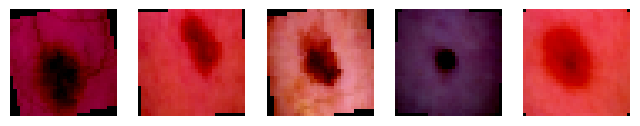

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def show_images(dataloader, num_images=5):
    # Get a batch of data
    data_iterator = iter(dataloader)
    _, _, images, _, _ = next(data_iterator)

    # Plot the images
    fig, axes = plt.subplots(1, num_images, figsize=(8, 6))
    for i in range(num_images):
        image = images[i].permute(1, 2, 0)  # Change tensor shape to (H, W, C) for plotting
        axes[i].imshow(image)
        axes[i].axis('off')
    plt.show()

# Call the function to display images
show_images(dataloader)


In [3]:
import torch
import torch.nn as nn

class PixelConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(PixelConvLayer, self).__init__()
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.conv(x)
        out = self.relu(out)
        return out

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.relu(out)
        out = self.conv2(out)
        out += residual
        out = self.relu(out)
        return out

class PixelCNN(nn.Module):
    def __init__(self):
        super(PixelCNN, self).__init__()
        self.pixel_conv_layer = PixelConvLayer(in_channels=128, out_channels=256)
        self.residual_blocks = nn.Sequential(
            ResidualBlock(channels=256),
            ResidualBlock(channels=256),
            ResidualBlock(channels=256),
            ResidualBlock(channels=256),
            ResidualBlock(channels=256)
        )
        self.pixel_conv_layer_6 = PixelConvLayer(in_channels=256, out_channels=128)
        self.pixel_conv_layer_7 = PixelConvLayer(in_channels=128, out_channels=128)
        self.conv2d_18 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=1)

    def forward(self, x):
        out = self.pixel_conv_layer(x)
        out = self.residual_blocks(out)
        out = self.pixel_conv_layer_6(out)
        out = self.pixel_conv_layer_7(out)
        out = self.conv2d_18(out)
        return out



In [4]:
import torch
from torch import nn
from torch.nn import functional as F

from torch import distributed as dist_fn
import wandb

class Quantize(nn.Module):
    def __init__(self, dim, n_embed, decay=0.99, eps=1e-5):
        super().__init__()

        self.dim = dim
        self.n_embed = n_embed
        self.decay = decay
        self.eps = eps

        embed = torch.randn(dim, n_embed)
        self.register_buffer("embed", embed)
        self.register_buffer("cluster_size", torch.zeros(n_embed))
        self.register_buffer("embed_avg", embed.clone())

    def forward(self, input):
        flatten = input.reshape(-1, self.dim)
        dist = (
            flatten.pow(2).sum(1, keepdim=True)
            - 2 * flatten @ self.embed
            + self.embed.pow(2).sum(0, keepdim=True)
        )
        _, embed_ind = (-dist).max(1)
        embed_onehot = F.one_hot(embed_ind, self.n_embed).type(flatten.dtype)
        embed_ind = embed_ind.view(*input.shape[:-1])
        quantize = self.embed_code(embed_ind)

        if self.training:
            embed_onehot_sum = embed_onehot.sum(0)
            embed_sum = flatten.transpose(0, 1) @ embed_onehot

            # dist_fn.all_reduce(embed_onehot_sum)
            # dist_fn.all_reduce(embed_sum)

            self.cluster_size.data.mul_(self.decay).add_(
                embed_onehot_sum, alpha=1 - self.decay
            )
            self.embed_avg.data.mul_(self.decay).add_(embed_sum, alpha=1 - self.decay)
            n = self.cluster_size.sum()
            cluster_size = (
                (self.cluster_size + self.eps) / (n + self.n_embed * self.eps) * n
            )
            embed_normalized = self.embed_avg / cluster_size.unsqueeze(0)
            self.embed.data.copy_(embed_normalized)

        # diff = (quantize.detach() - input).pow(2).mean()
        diff = (quantize - input).pow(2).mean()
        # quantize = input + (quantize - input).detach()
        quantize = input + (quantize - input)

        return quantize, diff, embed_ind

    def embed_code(self, embed_id):
        return F.embedding(embed_id, self.embed.transpose(0, 1))


class ResBlock(nn.Module):
    def __init__(self, in_channel, channel):
        super().__init__()

        self.conv = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(in_channel, channel, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channel, in_channel, 1),
        )

    def forward(self, input):
        out = self.conv(input)
        out += input

        return out


class Encoder(nn.Module):
    def __init__(self, in_channel, channel, n_res_block, n_res_channel, stride):
        super().__init__()

        if stride == 4:
            blocks = [
                nn.Conv2d(in_channel, channel // 2, 4, stride=2, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(channel // 2, channel, 4, stride=2, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(channel, channel, 3, padding=1),
            ]

        elif stride == 2:
            blocks = [
                nn.Conv2d(in_channel, channel // 2, 4, stride=2, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(channel // 2, channel, 3, padding=1),
            ]

        for i in range(n_res_block):
            blocks.append(ResBlock(channel, n_res_channel))

        blocks.append(nn.ReLU(inplace=True))

        self.blocks = nn.Sequential(*blocks)

    def forward(self, input):
        return self.blocks(input)


class Decoder(nn.Module):
    def __init__(
        self, in_channel, out_channel, channel, n_res_block, n_res_channel, stride
    ):
        super().__init__()

        blocks = [nn.Conv2d(in_channel, channel, 3, padding=1)]

        for i in range(n_res_block):
            blocks.append(ResBlock(channel, n_res_channel))

        blocks.append(nn.ReLU(inplace=True))

        if stride == 4:
            blocks.extend(
                [
                    nn.ConvTranspose2d(channel, channel // 2, 4, stride=2, padding=1),
                    nn.ReLU(inplace=True),
                    nn.ConvTranspose2d(
                        channel // 2, out_channel, 4, stride=2, padding=1
                    ),
                ]
            )

        elif stride == 2:
            blocks.append(
                nn.ConvTranspose2d(channel, out_channel, 4, stride=2, padding=1)
            )

        self.blocks = nn.Sequential(*blocks)

    def forward(self, input):
        return self.blocks(input)


class VQVAE(nn.Module):
    def __init__(
        self,
        in_channel=3,
        channel=128,
        n_res_block=2,
        n_res_channel=32,
        embed_dim=64,
        n_embed=512,
        decay=0.99,
    ):
        super().__init__()

        self.enc_b = Encoder(in_channel, channel, n_res_block, n_res_channel, stride=4)
        self.enc_t = Encoder(channel, channel, n_res_block, n_res_channel, stride=2)
        self.quantize_conv_t = nn.Conv2d(channel, embed_dim, 1)
        self.quantize_t = Quantize(embed_dim, n_embed)
        self.pixelcnn=PixelCNN()
        self.dec_t = Decoder(
            embed_dim, embed_dim, channel, n_res_block, n_res_channel, stride=2
        )
        self.quantize_conv_b = nn.Conv2d(embed_dim + channel, embed_dim, 1)
        self.quantize_b = Quantize(embed_dim, n_embed)
        self.upsample_t = nn.ConvTranspose2d(
            embed_dim, embed_dim, 4, stride=2, padding=1
        )
        self.dec = Decoder(
            embed_dim + embed_dim,
            in_channel,
            channel,
            n_res_block,
            n_res_channel,
            stride=4,
        )

    def forward(self, input):
        quant_t, quant_b, diff, _, _ = self.encode(input)

        dec = self.decode(quant_t, quant_b)

        return dec, diff

    def encode(self, input):
        enc_b = self.enc_b(input)
        enc_t = self.enc_t(enc_b)

        quant_t = self.quantize_conv_t(enc_t).permute(0, 2, 3, 1)
        quant_t, diff_t, id_t = self.quantize_t(quant_t)
        quant_t = quant_t.permute(0, 3, 1, 2)
        diff_t = diff_t.unsqueeze(0)

        dec_t = self.dec_t(quant_t)
        enc_b = torch.cat([dec_t, enc_b], 1)

        quant_b = self.quantize_conv_b(enc_b).permute(0, 2, 3, 1)
        quant_b, diff_b, id_b = self.quantize_b(quant_b)
        quant_b = quant_b.permute(0, 3, 1, 2)
        diff_b = diff_b.unsqueeze(0)

        return quant_t, quant_b, diff_t + diff_b, id_t, id_b

    def decode(self, quant_t, quant_b):
        upsample_t = self.upsample_t(quant_t)
        quant = torch.cat([upsample_t, quant_b], 1)
        # print("quant shape: ",quant.shape)
        quant = self.pixelcnn(quant)
        dec = self.dec(quant)

        return dec

    def decode_code(self, code_t, code_b):
        quant_t = self.quantize_t.embed_code(code_t)
        quant_t = quant_t.permute(0, 3, 1, 2)
        quant_b = self.quantize_b.embed_code(code_b)
        quant_b = quant_b.permute(0, 3, 1, 2)

        dec = self.decode(quant_t, quant_b)

        return dec

In [5]:
!wandb login --relogin 6e1118f48554030c79713c59e8803762b6025f7f

wandb: Appending key for api.wandb.ai to your netrc file: /home/cvlab/.netrc


In [6]:
# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="vq_vae_mask_git+pixel cnn",

    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.0003,
    "architecture": "VQVAE",
    "dataset": "ISIC",
    "epochs": 30,
    }
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: m22rm003 (m22rm003_kb). Use `wandb login --relogin` to force relogin


In [7]:
from torch import distributed as dist
from torchvision import datasets, transforms, utils
import os
from tqdm import tqdm
checkpoint_dir = "checkpoint_vqvaepixel"
os.makedirs(checkpoint_dir, exist_ok=True)
# Create the directory if it doesn't exist
save_dir = 'vqvaepluspixel'
os.makedirs(save_dir, exist_ok=True)

def train(epoch, loader, model, optimizer, device):
  
    model.train()
    criterion = nn.MSELoss()

    latent_loss_weight = 0.25
    sample_size = 25
    epoch_train_loss = 0

    mse_sum = 0
    mse_n = 0

    for i, (label, sketch, img, img_name, rand_label) in tqdm(enumerate(loader), total=len(loader)):

        model.zero_grad()

        img = img.to(device)
        sketch = sketch.to(device)

        out, latent_loss = model(img)
        recon_loss = criterion(out, img)
        latent_loss = latent_loss.mean()
        # print("latent_loss: ",latent_loss)
        # print("recon_loss: ",recon_loss)
        loss = recon_loss + latent_loss_weight * latent_loss
        epoch_train_loss += loss.item()
        # 

        loss.backward()

        # if scheduler is not None:
        #     scheduler.step()
        optimizer.step()

        # part_mse_sum = recon_loss.item() * img.shape[0]
        # part_mse_n = img.shape[0]
        # comm = {"mse_sum": part_mse_sum, "mse_n": part_mse_n}
        # # comm = dist.all_gather(comm)

        # for part in comm:
        #     mse_sum += part["mse_sum"]
        #     mse_n += part["mse_n"]
        part_mse_sum = recon_loss.item() * img.shape[0]
        part_mse_n = img.shape[0]
        comm = {"mse_sum": part_mse_sum, "mse_n": part_mse_n}
        # comm = dist.all_gather(comm)

        for key, value in comm.items():  # Use .items() to iterate over key-value pairs
            if key == "mse_sum":
                mse_sum += value
            elif key == "mse_n":
                mse_n += value

        # if dist.is_primary():
        lr = optimizer.param_groups[0]["lr"]

      

        if i % 100 == 0:
            model.eval()

            sample = img[:sample_size]

            with torch.no_grad():
                out, _ = model(sample)

            utils.save_image(
                torch.cat([sample, out], 0),
                f"vqvaepluspixel/{str(epoch + 1).zfill(5)}_{str(i).zfill(5)}.png",
                nrow=sample_size,
                normalize=True,
                range=(-1, 1),
            )
        avg_train_loss = epoch_train_loss / len(dataloader)
        model.train()

    wandb.log({
    "epoch": epoch + 1,
    "loss" : avg_train_loss})


In [8]:
from math import cos, pi, floor, sin

class Phase:
    def __init__(self, start, end, n_iter, anneal_fn):
        self.start, self.end = start, end
        self.n_iter = n_iter
        self.anneal_fn = anneal_fn
        self.n = 0

    def step(self):
        self.n += 1

        return self.anneal_fn(self.start, self.end, self.n / self.n_iter)

    def reset(self):
        self.n = 0

    @property
    def is_done(self):
        return self.n >= self.n_iter
    
class CycleScheduler:
    def __init__(
        self,
        optimizer,
        lr_max,
        n_iter,
        momentum=(0.95, 0.85),
        divider=25,
        warmup_proportion=0.3,
        phase=('linear', 'cos'),
    ):
        self.optimizer = optimizer

        phase1 = int(n_iter * warmup_proportion)
        phase2 = n_iter - phase1
        lr_min = lr_max / divider

        phase_map = {'linear': self.anneal_linear, 'cos': self.anneal_cos}

        self.lr_phase = [
            Phase(lr_min, lr_max, phase1, phase_map[phase[0]]),
            Phase(lr_max, lr_min / 1e4, phase2, phase_map[phase[1]]),
        ]

        self.momentum = momentum

        if momentum is not None:
            mom1, mom2 = momentum
            self.momentum_phase = [
                Phase(mom1, mom2, phase1, phase_map[phase[0]]),
                Phase(mom2, mom1, phase2, phase_map[phase[1]]),
            ]

        else:
            self.momentum_phase = []

        self.phase = 0

    def anneal_linear(start, end, proportion):
        return start + proportion * (end - start)


    def anneal_cos(start, end, proportion):
        cos_val = cos(pi * proportion) + 1

    def step(self):
        lr = self.lr_phase[self.phase].step()

        if self.momentum is not None:
            momentum = self.momentum_phase[self.phase].step()

        else:
            momentum = None

        for group in self.optimizer.param_groups:
            group['lr'] = lr

            if self.momentum is not None:
                if 'betas' in group:
                    group['betas'] = (momentum, group['betas'][1])

                else:
                    group['momentum'] = momentum

        if self.lr_phase[self.phase].is_done:
            self.phase += 1

        if self.phase >= len(self.lr_phase):
            for phase in self.lr_phase:
                phase.reset()

            for phase in self.momentum_phase:
                phase.reset()

            self.phase = 0

        return lr, momentum

In [9]:
lr = 3e-4
epoch = 25

model = VQVAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

checkpoint = torch.load("/media/cvlab/EXT_HARD_DRIVE1/Karan/A5/checkpoint_final_code/vqvae_030.pt")
# model.eval()  # Set VQVAE model to evaluation mode

# vqvae_state_dict = torch.load(checkpoint)
vqvae_state_dict = checkpoint['state_dict'] if 'state_dict' in checkpoint else checkpoint


# Load the state_dict to the PixelCNN model
model.load_state_dict(vqvae_state_dict, strict=False)  # strict=False allows for loading partial state_dicts

# for param in model.parameters():
#     param.requires_grad = False  # Freeze VQVAE parameters

# scheduler = CycleScheduler(
#             optimizer,
#             lr,
#             n_iter=len(dataloader) * epoch,
#             momentum=None,
#             warmup_proportion=0.05,)

for i in range(epoch):
    train(i, dataloader, model, optimizer,device)

    # if dist.is_primary():
    torch.save(model.state_dict(), f"{checkpoint_dir}/{str(i + 1).zfill(3)}.pt")
wandb.finish()


 95%|█████████▌| 268/282 [10:31<00:33,  2.41s/it]

In [ ]:

test_dataset = SketchDataset(csv_file='/home/cvlab/Karan/A_3/Dataset_A4/Test_data/Test_labels.csv', 
                              image_root_dir='/home/cvlab/Karan/A_3/Dataset_A4/Test_data/Test_images',
                              sketch_root_dir='/home/cvlab/Karan/A_3/Dataset_A4/Test_data/Unpaired_test_sketch',
                              transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
import torch
from torchvision.utils import save_image

model = VQVAE().to(device)
model.load_state_dict(torch.load('/media/cvlab/EXT_HARD_DRIVE1/Karan/A5/checkpoint_vqvaepixel_100.pt'))
model.eval()

# Define a directory to save the images
output_dir = "vqvae_pixel_output_test"
os.makedirs(output_dir, exist_ok=True)


# Step 3: Test the model
for i, (label, sketch, img, img_name, rand_label) in enumerate(test_dataloader):
    # Assuming each batch contains input images
   
    img= img.to(device)
    # Forward pass
    with torch.no_grad():
        output_images, latent_loss = model(img)
     
    
    # Concatenate input ground truth images and generated images
    concatenated_images = torch.cat([img, output_images], dim=0)

    # Save the concatenated images
    save_image(concatenated_images, 
               os.path.join(output_dir, f"batch_{i}.png"),
               nrow=img.shape[0],  # Assuming batch size is the number of images in a row
               normalize=True, 
               range=(-1, 1))

